In [28]:
# !pip install -U scikit-learn

In [29]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import log_loss
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datos_2c2020_tp2.models.log.Logger as logger

In [30]:
train = pd.read_csv("../datasets/xgb-train.csv")
test = pd.read_csv("../datasets/xgb-test.csv")

In [31]:
# train['Week_Day'].describe()

# TP2 - XGBoost Binary Classifier


Luego verifico que dropear filas que se overlapean con test implica
dejar de lado la mayoria de datos por lo cual no se tendraa en cuenta.
(djo el codigo de dropeo comentaado)

-----------------------------------------


# Seteo de features

In [32]:
target = "target"
features = list(train.columns)
features.remove(target)
features.remove("Opportunity_ID")

#VANILLA NO
# features.remove("delivery_delay")
# features.remove("opportunity_lifetime")
# features.remove("converted_taxable_amount")
# features.remove("last_modified_to_delivery")
# features.remove("currency_conversion_rate")
# features.remove("Occur")
# features.remove("delivery_window")
# features.remove("account_creation_to_created_opp")

#VANILLA SI
features.remove('Total_Taxable_Amount')
features.remove('ASP_(converted)')
features.remove("ASP")
features.remove("Total_Amount")
features.remove("Delivery_Year")
# features.remove("Week_Day")

#CONSIDERO REMOVIBLES
features.remove("created_blocknum")   #FECHA!!
features.remove("late_delivery_blocknum")
features.remove("early_delivery_blocknum")
features.remove("last_modified_blocknum")
features.remove("account_creation_blocknum") #OJO CCON HIPOTESIS DEL CLIENTE VIEEJO
print("Features totales: {}".format(len(features)))



Features totales: 114


# Armado de sets
FORMAS:

In [33]:
X_train, y_train = train.loc[:,features], train.loc[:,target]
X_test_Opp = test.loc[:,"Opportunity_ID"]
X_test = test.loc[:,features]

print("Set de entrenamiento (size) {}".format(X_train.shape))
print("Set de testing (size) {}".format(X_test.shape))

Set de entrenamiento (size) (16947, 114)
Set de testing (size) (2551, 114)


Por otra parte seepaaro el test de entrenamiento en aprox~(80%/20%) segun la fecha de creeacion de la oportunidad.

In [34]:
percent_80 = train["created_blocknum"].describe()['75%']/0.945
beta_test = train[train["created_blocknum"]>percent_80]
beta_train = train[train["created_blocknum"]<percent_80]

In [35]:
A_train, b_train = beta_train.loc[:,features], beta_train.loc[:,target]
# A_test_Opp = beta_test.loc[:,"Opportunity_ID"]
A_test, b_test = beta_test.loc[:,features], beta_test.loc[:,target]

print("Set de entrenamiento secundario (size) {}".format(A_train.shape))
print("Set de testing secundario (size) {}".format(A_test.shape))

Set de entrenamiento secundario (size) (14078, 114)
Set de testing secundario (size) (2869, 114)


In [36]:

dtrain = xgb.DMatrix(X_train, label=y_train)



# Tuneo de hiperparametros
* GRIDSEARCH + CROSS VALIDATION

Configuracion

In [37]:
#------------------------------------------------------------------------------------------
#------------------------------------------------------------------------------------------
#----------------------------- C O N F I G U R A C I O N ----------------------------------
#------------------------------------------------------------------------------------------
#------------------------------------------------------------------------------------------


params = {"objective": "binary:logistic",
          'colsample_bytree': 0.3,
          'subsample': 1.0,
          'learning_rate': 0.1,
          'max_depth': 6,
          'min_child_weight': 1,
          'eval_metric': 'logloss'}

nfolds = 7
rounds = 160
early_stopping_rounds = 10

enaable_gridsearch_for_tree = False
enaable_gridsearch_for_sampling = False
enaable_gridsearch_for_learning = False
final_cv = False
enable_parcial_training = True

print("Usando nfolds={},  num_boost_round={}"
      "  y  early_stopping_rounds={}".format(nfolds, rounds, early_stopping_rounds))

#------------------------------------------------------------------------------------------
#------------------------------------------------------------------------------------------
#------------------------------------------------------------------------------------------
#------------------------------------------------------------------------------------------

Usando nfolds=7,  num_boost_round=160  y  early_stopping_rounds=10


TUNEO DE:
* max_depth
* min_child_weight

In [38]:
if enaable_gridsearch_for_tree:
    gridsearch_params = [
        (max_depth, min_child_weight)
        for max_depth in range(1,9)
        for min_child_weight in range(1,2)
    ]

    # Define initial best params and LogLoss
    min_logloss = float("Inf")
    best_params = None
    for max_depth, min_child_weight in gridsearch_params:
        print("CV with max_depth={}, min_child_weight={}".format(
                                 max_depth,
                                 min_child_weight))
        # Update our parameters
        params['max_depth'] = max_depth
        params['min_child_weight'] = min_child_weight
        # Run CV
        cv_results = xgb.cv(
            params,
            dtrain,
            num_boost_round=rounds,
            seed=151243,
            nfold=nfolds,
            metrics='logloss',
            early_stopping_rounds=early_stopping_rounds
        )
        # Update best LogLoss
        mean_logloss = cv_results['test-logloss-mean'].min()
        boost_rounds = cv_results['test-logloss-mean'].argmin()
        print("\tLL {} for {} rounds".format(mean_logloss, boost_rounds+1))
        if mean_logloss < min_logloss:
            min_logloss = mean_logloss
            best_params = (max_depth,min_child_weight)
    print("Best max_depth,min_child_weight: {}, {}, LogLoss: {}".format(best_params[0], best_params[1], min_logloss))

    params['max_depth'] = best_params[0]
    params['min_child_weight'] = best_params[1]

TUNEO DE:
* subsamble
* colsample_bytree


In [39]:
if enaable_gridsearch_for_sampling:
    gridsearch_params = [
        (subsample, colsample_bytree)
        for subsample in [i/10. for i in range(8,11)]
        for colsample_bytree in  [i/10. for i in range(3,5)]
    ]

    # Define initial best params and LogLoss
    min_logloss = float("Inf")
    best_params = None
    for subsample, colsample_bytree in gridsearch_params:
        print("CV with subsample={}, colsample_bytree={}".format(
                                 subsample,
                                 colsample_bytree))
        # Update our parameters
        params['subsample'] = subsample
        params['colsample_bytree'] = colsample_bytree
        # Run CV
        cv_results = xgb.cv(
            params,
            dtrain,
            num_boost_round=rounds,
            seed=151243,
            nfold=nfolds,
            metrics='logloss',
            early_stopping_rounds=early_stopping_rounds
        )
        # Update best LogLoss
        mean_logloss = cv_results['test-logloss-mean'].min()
        boost_rounds = cv_results['test-logloss-mean'].argmin()
        print("\tLL {} for {} rounds".format(mean_logloss, boost_rounds+1))
        if mean_logloss < min_logloss:
            min_logloss = mean_logloss
            best_params = (subsample,colsample_bytree)
    print("Best subsample,colsample_bytree: {}, {}, LogLoss: {}".format(best_params[0], best_params[1], min_logloss))

    params['subsample'] = best_params[0]
    params['colsample_bytree'] = best_params[1]

TUNEO DE:
* learning rate (eta)

In [40]:
if enaable_gridsearch_for_learning:
    min_logloss = float("Inf")
    best_learning_rate = None
    for learning_rate in [0.2, 0.15, 0.1, 0.05]:
        print("CV with learning_rate={}".format(learning_rate))
        # Update our parameters
        params['learning_rate'] = learning_rate
        # Run CV
        cv_results = xgb.cv(
            params,
            dtrain,
            num_boost_round=rounds,
            seed=151243,
            nfold=nfolds,
            metrics='logloss',
            early_stopping_rounds=early_stopping_rounds
        )
        # Update best LogLoss
        mean_logloss = cv_results['test-logloss-mean'].min()
        boost_rounds = cv_results['test-logloss-mean'].argmin()
        print("\tLL {} for {} rounds".format(mean_logloss, boost_rounds+1))
        if mean_logloss < min_logloss:
            min_logloss = mean_logloss
            best_learning_rate = learning_rate
    print("Best learning_rate: {}, LogLoss: {}".format(best_learning_rate, min_logloss))

Final cross validation error

In [41]:
if final_cv:
    cv_results = xgb.cv(
                params,
                dtrain,
                num_boost_round=999,
                seed=151243,
                nfold=len(features),
                metrics='logloss',
                early_stopping_rounds=early_stopping_rounds
            )
    print("Rounds    LogLoss \n  {}.".format(cv_results["test-logloss-mean"].tail(1)))


# Entrenamiento

In [42]:
xgb_clf = xgb.XGBClassifier(objective ='binary:logistic',
            eval_metric='logloss',
            use_label_encoder=False,
            colsample_bytree = params['colsample_bytree'],
            subsample = params['learning_rate'],
            learning_rate = params['learning_rate'],
            max_depth = params['max_depth'],
            n_estimators = rounds,
            reg_alpha=0,
            min_child_weight = params['min_child_weight'])


xgb_clf.fit(X_train,y_train)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=160, n_jobs=8,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=0.1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

In [43]:
preds = [pred[0] for pred in xgb_clf.predict_proba(X_test)]
# preds

# ENTRENAMIENTO PARCIAL
CALCULO DE ERROR EN BASE A PARTICION DE SET DE ENTRENAMIENTO POR FECHA DE CREACION DE LA OPORTUNIDAD

In [44]:
if enable_parcial_training:
    print("\n TUNEANDO ALPHA \n")
    min_logloss = float("Inf")
    best_alpha = None
    for alpha in range(0,11):
        print("alpha={}".format(alpha))
        # Update our parameters
        params['alpha'] = alpha
        # Run CV
        beta_xgb_clf = xgb.XGBClassifier(objective ='binary:logistic', eval_metric='logloss', use_label_encoder=False,
                    colsample_bytree = params['colsample_bytree'],
                    subsample = params['subsample'],
                    learning_rate = params['learning_rate'],
                    max_depth = params['max_depth'],
                    n_estimators = rounds,
                    reg_alpha=params['alpha'],
                    min_child_weight = params['min_child_weight'])
        beta_xgb_clf.fit(A_train,b_train)
        beta_preds = [pred[1] for pred in beta_xgb_clf.predict_proba(A_test)]
        print("Log loss: {}".format(log_loss(b_test, beta_preds)))
        # Update best LogLoss
        mean_logloss = log_loss(b_test, beta_preds)
        if mean_logloss < min_logloss:
            min_logloss = mean_logloss
            best_alpha = alpha
    print("Best alpha: {}, LogLoss: {}".format(best_alpha, min_logloss))
    params['alpha'] = best_alpha


    print("\n TUNEANDO TREE_PARAMS \n")


    tree_params = [
        (max_depth, min_child_weight)
        for max_depth in range(1,11)
        for min_child_weight in range(1,5)
    ]
    min_logloss = float("Inf")
    best_params = None
    for max_depth, min_child_weight in tree_params:
        print("max_depth={}, min_child_weight={}".format(
                                 max_depth,
                                 min_child_weight))
        # Update our parameters
        params['max_depth'] = max_depth
        params['min_child_weight'] = min_child_weight
        # Run CV
        beta_xgb_clf = xgb.XGBClassifier(objective ='binary:logistic', eval_metric='logloss', use_label_encoder=False,
                    colsample_bytree = params['colsample_bytree'],
                    subsample = params['subsample'],
                    learning_rate = params['learning_rate'],
                    max_depth = params['max_depth'],
                    n_estimators = rounds,
                    reg_alpha=params['alpha'],
                    min_child_weight = params['min_child_weight'])
        beta_xgb_clf.fit(A_train,b_train)
        beta_preds = [pred[1] for pred in beta_xgb_clf.predict_proba(A_test)]
        print("Log loss: {}".format(log_loss(b_test, beta_preds)))
        # Update best LogLoss
        mean_logloss = log_loss(b_test, beta_preds)
        if mean_logloss < min_logloss:
            min_logloss = mean_logloss
            best_params = (max_depth,min_child_weight)
    print("Best max_depth,min_child_weight: {}, {}, LogLoss: {}".format(best_params[0], best_params[1], min_logloss))
    params['max_depth'] = best_params[0]
    params['min_child_weight'] = best_params[1]



    print("\n TUNEANDO sample_params \n")


    min_logloss = float("Inf")
    best_params = None
    sample_params = [
        (subsample, colsample_bytree)
        for subsample in [i/10. for i in range(6,11)]
        for colsample_bytree in  [i/10. for i in range(1,5)]
    ]
    for subsample, colsample_bytree in sample_params:
        print("subsample={}, colsample_bytree={}".format(
                                 subsample,
                                 colsample_bytree))
        params['subsample'] = subsample
        params['colsample_bytree'] = colsample_bytree
        # Run CV
        beta_xgb_clf = xgb.XGBClassifier(objective ='binary:logistic', eval_metric='logloss', use_label_encoder=False,
                    colsample_bytree = params['colsample_bytree'],
                    subsample = params['subsample'],
                    learning_rate = params['learning_rate'],
                    max_depth = params['max_depth'],
                    n_estimators = rounds,
                    reg_alpha=params['alpha'],
                    min_child_weight = params['min_child_weight'])
        beta_xgb_clf.fit(A_train,b_train)
        beta_preds = [pred[1] for pred in beta_xgb_clf.predict_proba(A_test)]
        print("Log loss: {}".format(log_loss(b_test, beta_preds)))
        # Update best LogLoss
        mean_logloss = log_loss(b_test, beta_preds)
        if mean_logloss < min_logloss:
            min_logloss = mean_logloss
            best_params = (subsample,colsample_bytree)
    print("Best subsample,colsample_bytree: {}, {}, LogLoss: {}".format(best_params[0], best_params[1], min_logloss))
    params['subsample'] = best_params[0]
    params['colsample_bytree'] = best_params[1]

    print("\n TUNEANDO learning_rate \n")

    min_logloss = float("Inf")
    best_learning_rate = None
    for learning_rate in [0.2, 0.15, 0.1, 0.05]:
        print("learning_rate={}".format(learning_rate))
        # Update our parameters
        params['learning_rate'] = learning_rate
        # Run CV
        beta_xgb_clf = xgb.XGBClassifier(objective ='binary:logistic', eval_metric='logloss', use_label_encoder=False,
                    colsample_bytree = params['colsample_bytree'],
                    subsample = params['subsample'],
                    learning_rate = params['learning_rate'],
                    max_depth = params['max_depth'],
                    n_estimators = rounds,
                    reg_alpha=params['alpha'],
                    min_child_weight = params['min_child_weight'])
        beta_xgb_clf.fit(A_train,b_train)
        beta_preds = [pred[1] for pred in beta_xgb_clf.predict_proba(A_test)]
        print("Log loss: {}".format(log_loss(b_test, beta_preds)))
        # Update best LogLoss
        mean_logloss = log_loss(b_test, beta_preds)
        if mean_logloss < min_logloss:
            min_logloss = mean_logloss
            best_learning_rate = learning_rate
    print("Best learning_rate: {}, LogLoss: {}".format(best_learning_rate, min_logloss))
    params['learning_rate'] = best_learning_rate




 TUNEANDO ALPHA 

alpha=0
Log loss: 0.29932603675232805
alpha=1
Log loss: 0.3037232685369847
alpha=2
Log loss: 0.30441948732080565
alpha=3
Log loss: 0.3093058417449006
alpha=4
Log loss: 0.3061298649874678
alpha=5
Log loss: 0.312757959329913
alpha=6
Log loss: 0.3159206481891093
alpha=7
Log loss: 0.31449363889704557
alpha=8
Log loss: 0.31758873572188556
alpha=9
Log loss: 0.32272196234327716
alpha=10
Log loss: 0.3245050307730615
Best alpha: 0, LogLoss: 0.29932603675232805

 TUNEANDO TREE_PARAMS 

max_depth=1, min_child_weight=1
Log loss: 0.37008960230749766
max_depth=1, min_child_weight=2
Log loss: 0.37008960230749766
max_depth=1, min_child_weight=3
Log loss: 0.37008960230749766
max_depth=1, min_child_weight=4
Log loss: 0.37008960230749766
max_depth=2, min_child_weight=1
Log loss: 0.32450313126722624
max_depth=2, min_child_weight=2
Log loss: 0.3273461878346336
max_depth=2, min_child_weight=3
Log loss: 0.3257257234857477
max_depth=2, min_child_weight=4
Log loss: 0.3239223281339602
max_dep

In [45]:
beta_xgb_clf = xgb.XGBClassifier(objective ='binary:logistic', eval_metric='logloss', use_label_encoder=False,
                    subsample = 1.0,
                    colsample_bytree = 0.3,
                    learning_rate = 0.1,
                    max_depth = 4,
                    n_estimators = rounds,
                    reg_alpha=0,
                    min_child_weight = 3)
beta_xgb_clf.fit(X_train,y_train)
beta_preds = [pred[1] for pred in beta_xgb_clf.predict_proba(X_test)]
beta_pred_df = pd.DataFrame(X_test_Opp)
beta_pred_df["Target"] = beta_preds
beta_pred_df = beta_pred_df.drop_duplicates("Opportunity_ID")
beta_pred_df.to_csv("../submits/xgb-clf-tunned-beta.csv", index=False)

Guardando las predicciones a CSV

In [46]:
pred_df = pd.DataFrame(X_test_Opp)
pred_df["Target"] = preds
pred_df = pred_df.drop_duplicates("Opportunity_ID")
display(pred_df)
pred_df.to_csv("../submits/xgb-bc1.csv",index=False)

,Opportunity_ID,Target
0,10689,0.173057
3,10690,0.446207
8,10691,0.892152
9,10692,0.545136
15,10693,0.021387
...,...,...
2545,12364,0.012389
2547,12365,0.763623
2548,12366,0.863852
2549,12367,0.672451


{'objective': 'binary:logistic', 'colsample_bytree': 0.3, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 3, 'eval_metric': 'logloss', 'alpha': 0}


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

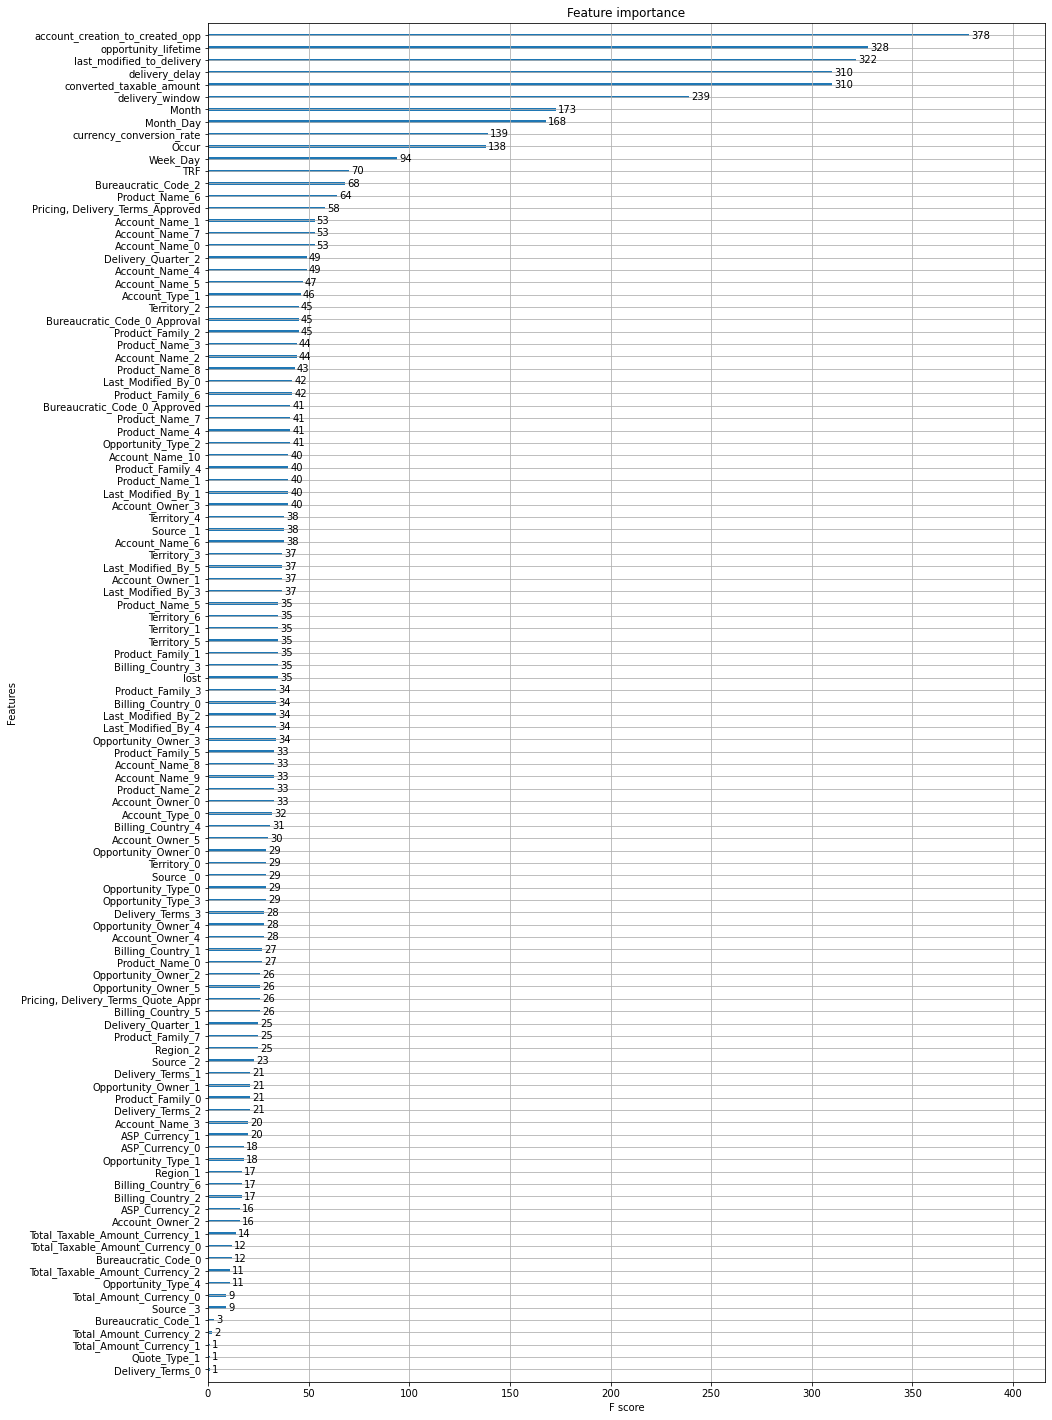

In [47]:
print(params)
plt.rcParams['figure.figsize'] = [15, 25]
xgb.plot_importance(xgb_clf)


In [48]:
# logger.Logger.log_model("xgb-logloss", params, features, cv_score)